In [1]:
import random
import numpy as np
import time
from sklearn.model_selection import train_test_split

In [2]:
class Network(object):
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x,y in zip(sizes[:-1], sizes[1:])]
        self.history = d = {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []}
    
    def feed_forward(self, activation):
        for bias, weight in zip(self.biases, self.weights):
            activation = sigmoid(np.dot(weight, activation) + bias.transpose()[0])
        return activation
    
    def fit(self, training_data, epochs, mini_batch_size, learning_rate,
            momentum=0, validation_data=None, validation_split=0.0):
        if validation_split != 0.0 and not validation_data :
            training_data, validation_data = train_test_split(training_data, test_size=validation_split, random_state=42)
        n_training = len(training_data)
        if validation_data or validation_split != 0.0: 
            n_validation = len(validation_data)
            print("Train on {} samples, validate on {} samples".format(n_training, n_validation))
        for epoch in range(epochs):
            mini_batches = [training_data[k:k + mini_batch_size] for k in range(0, n_training, mini_batch_size)]
            previous_weights = self.weights
            previous_biases =self.biases
            first = True
            for mini_batch in mini_batches:
                if first: previous_weights, previous_biases = self.weights, self.biases
                start = time.time()
                previous_weights, previous_biases = self.update_mini_batch(mini_batch, 
                                                                           learning_rate,
                                                                           momentum, 
                                                                           previous_weights, 
                                                                           previous_biases)
                end = time.time() - start
            if validation_data or validation_split != 0:
                training_accuracy, training_loss = self.evaluate(mini_batches[0])
                validation_accuracy, validation_loss = self.evaluate(validation_data)
                self.history['acc'].append(training_accuracy)
                self.history['val_acc'].append(validation_accuracy)
                self.history['loss'].append(training_loss)
                self.history['val_loss'].append(validation_loss)
                print("Epoch {}/{} : {} s - loss: {} - acc: {} - val_loss: {} - val_acc: {}".format(epoch + 1, 
                                                                                                    epochs,
                                                                                                    end,
                                                                                                    training_loss,
                                                                                                    training_accuracy,
                                                                                                    validation_loss,
                                                                                                    validation_accuracy))
            else :
                print("Epoch {} complete.".format(epoch + 1))
        
    def update_mini_batch(self, mini_batch, learning_rate, momentum, previous_weights, previous_biases):
        nabla_biases = [np.zeros(bias.shape) for bias in self.biases]
        nabla_weights = [np.zeros(weight.shape) for weight in self.weights]
        for x, y in mini_batch:
            delta_nabla_bias, delta_nabla_weights = self.backpropagation(x, y)
            nabla_biases = [nb + dnb for nb, dnb in zip(nabla_biases, delta_nabla_bias)]
            nabla_weights = [nw + dnw for nw, dnw in zip(nabla_weights, delta_nabla_weights)]
        temp_weights = self.weights
        temp_biases = self.biases
        self.weights = [w + momentum * pw + (learning_rate/len(mini_batch)) * nw 
                        for w, nw, pw in zip(self.weights, nabla_weights, previous_weights)]
        self.biases = [b + momentum * pb + (learning_rate/len(mini_batch)) * nb 
                       for b, nb, pb in zip(self.biases, nabla_biases, previous_biases)]
        return (temp_weights, temp_biases)
        
    def backpropagation(self, x, y):
        nabla_bias = [np.zeros(bias.shape) for bias in self.biases]
        nabla_weights = [np.zeros(weight.shape) for weight in self.weights]
        
        activation = x
        activations = [x]
        z_vectors = []
        
        for bias, weight in zip(self.biases, self.weights):
            z = np.dot(weight, activation) + bias.transpose()[0]
            z_vectors.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(z_vectors[-1])
        nabla_bias[-1] = delta
        delta_newaxis = delta[:, np.newaxis]
        m = len(activations[-2])
        activations_newaxis = activations[-2][:, np.newaxis].reshape(1, m)
        nabla_weights[-1] = np.dot(delta_newaxis, activations_newaxis)
        
        for layer in range(2, self.num_layers):
            z = z_vectors[-layer]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * sp
            nabla_bias[-layer] = delta
            delta_newaxis = delta[:, np.newaxis]
            m = len(activations[-layer-1].transpose())
            activations_newaxis = activations[-layer-1].transpose()[:, np.newaxis].reshape(1, m)
            nabla_weights[-layer] = np.dot(delta_newaxis, activations_newaxis)
        
        return (nabla_bias, nabla_weights)
    
    def evaluate(self, test_data):
        test_results = [(1 if self.feed_forward(x) * 2 >= 1 else 0, y) for x, y in test_data]
        accuracy = sum(int(x == y) for x, y in test_results)/len(test_results)
        loss = sum(pow(int(y - x), 2) for x, y in test_results)/len(test_results)
        return accuracy, loss
    
    def predict(self, test_data):
        test_results = [1 if self.feed_forward(x) * 2 >= 1 else 0 for x, y in test_data]
        return (test_results)
    
    def cost_derivative(self, output_activations, y):
        return np.squeeze(y - output_activations)

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [3]:
from sklearn import datasets, metrics

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data[0:100], iris.target[0:100],
                                                    test_size=0.2, random_state=42)

In [6]:
train_data = [(x, y) for x, y in zip(X_train, y_train)]
test_data = [(x, y) for x, y in zip(X_test, y_test)]

neural_network = Network([4, 5, 10, 1])
neural_network.fit(train_data, 50, 5, 0.1, momentum=0.0001, validation_split=0.25)

Train on 60 samples, validate on 20 samples
Epoch 1/50 : 0.00034880638122558594 s - loss: 0.4 - acc: 0.6 - val_loss: 0.6 - val_acc: 0.4
Epoch 2/50 : 0.0003809928894042969 s - loss: 0.4 - acc: 0.6 - val_loss: 0.6 - val_acc: 0.4
Epoch 3/50 : 0.00042319297790527344 s - loss: 0.4 - acc: 0.6 - val_loss: 0.6 - val_acc: 0.4
Epoch 4/50 : 0.0004203319549560547 s - loss: 0.4 - acc: 0.6 - val_loss: 0.6 - val_acc: 0.4
Epoch 5/50 : 0.00042247772216796875 s - loss: 0.4 - acc: 0.6 - val_loss: 0.6 - val_acc: 0.4
Epoch 6/50 : 0.00042247772216796875 s - loss: 0.4 - acc: 0.6 - val_loss: 0.6 - val_acc: 0.4
Epoch 7/50 : 0.0004222393035888672 s - loss: 0.4 - acc: 0.6 - val_loss: 0.6 - val_acc: 0.4
Epoch 8/50 : 0.00042128562927246094 s - loss: 0.6 - acc: 0.4 - val_loss: 0.6 - val_acc: 0.4
Epoch 9/50 : 0.00042700767517089844 s - loss: 0.6 - acc: 0.4 - val_loss: 0.5 - val_acc: 0.5
Epoch 10/50 : 0.00042319297790527344 s - loss: 0.6 - acc: 0.4 - val_loss: 0.4 - val_acc: 0.6
Epoch 11/50 : 0.0004222393035888672 s 

In [7]:
import matplotlib.pyplot as plt

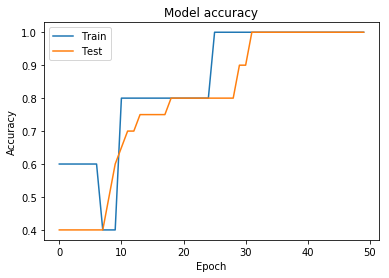

In [8]:
plt.plot(neural_network.history['acc'])
plt.plot(neural_network.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

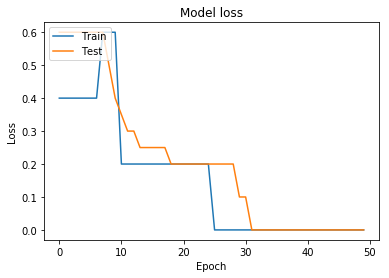

In [9]:
plt.plot(neural_network.history['loss'])
plt.plot(neural_network.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
accuracy, loss = neural_network.evaluate(test_data)
accuracy

1.0